In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='1'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
INPUT_CSV_PATH = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2.csv')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_1_20250325_0229


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(INPUT_CSV_PATH, DEVICE)

Loading Profiles: 3891424it [03:38, 17829.19it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_1_20250325_0229/density_plot.png


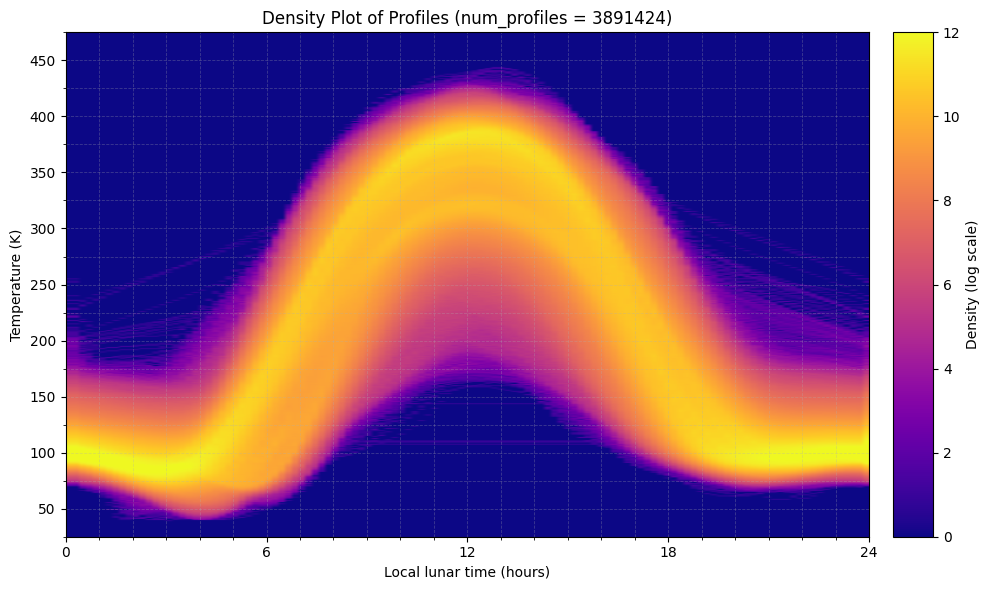

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

Saved figure to /workspace/outputs/profiles_v2_experiment_1_20250325_0229/histogram_max_temp.png


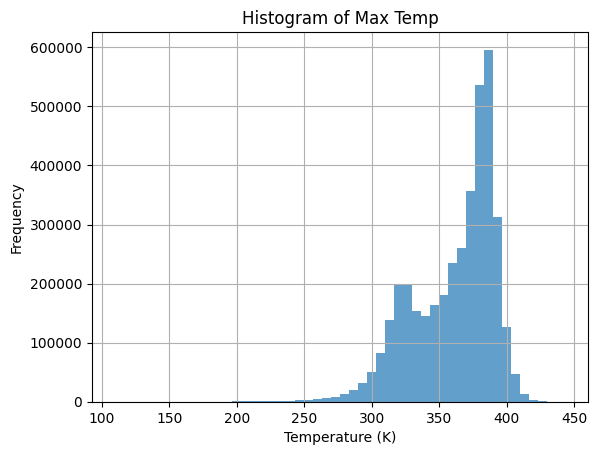

Saved figure to /workspace/outputs/profiles_v2_experiment_1_20250325_0229/histogram_min_temp.png


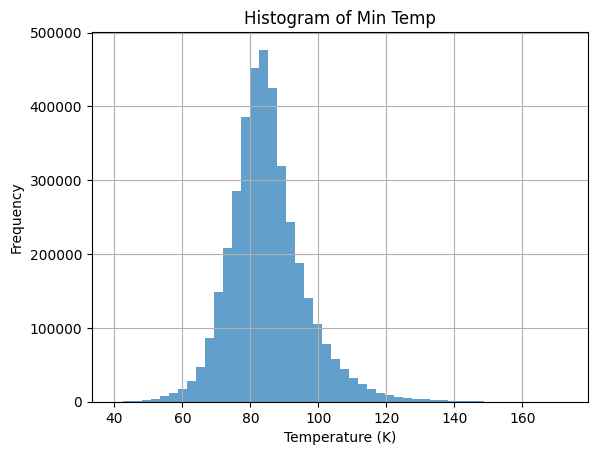

Saved figure to /workspace/outputs/profiles_v2_experiment_1_20250325_0229/histogram_mean_temp.png


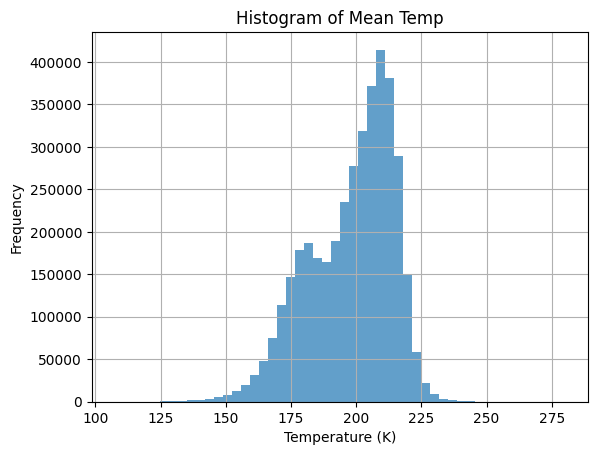

Saved figure to /workspace/outputs/profiles_v2_experiment_1_20250325_0229/histogram_std_temp.png


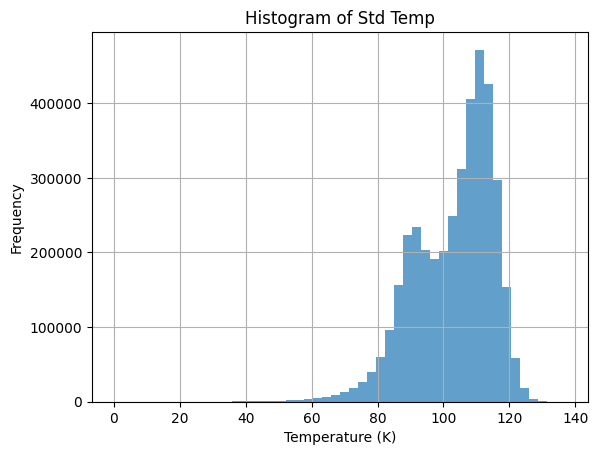

In [5]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(PROFILE_LIST_JSON)
statistics = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotHistograms(statistics, output_dir=model_dir)

In [6]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 197.9884
STD: 104.6083
Min Temp: 40.0240
Max Temp: 443.4440
Datasets:
Training Data: 2723996
Validation Data: 778284
Test Data: 389144


In [7]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 13620/13620 [07:02<00:00, 32.20it/s, best_loss=0.5770]


[Training] Epoch 1/100, L1 Loss: 0.5795, L2 Loss: 0.6067, KL Loss: 0.6065, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 3892/3892 [00:33<00:00, 116.75it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5516, Val KL Loss: 0.6102
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 2/100: 100%|██████████| 13620/13620 [07:14<00:00, 31.38it/s, best_loss=0.5817]


[Training] Epoch 2/100, L1 Loss: 0.5727, L2 Loss: 0.5972, KL Loss: 0.6125, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 3892/3892 [00:40<00:00, 96.54it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5508, Val KL Loss: 0.6142
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 3/100: 100%|██████████| 13620/13620 [07:38<00:00, 29.73it/s, best_loss=0.5730]


[Training] Epoch 3/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6129, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 3892/3892 [00:40<00:00, 96.07it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5536, Val KL Loss: 0.6005


[Training] Epoch 4/100: 100%|██████████| 13620/13620 [07:36<00:00, 29.87it/s, best_loss=0.5641]


[Training] Epoch 4/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6130, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 3892/3892 [00:42<00:00, 91.47it/s] 


[Validation] Epoch 4/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5508, Val KL Loss: 0.6059
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 5/100: 100%|██████████| 13620/13620 [07:36<00:00, 29.86it/s, best_loss=0.5685]


[Training] Epoch 5/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 3892/3892 [00:41<00:00, 93.39it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5509, Val KL Loss: 0.6091


[Training] Epoch 6/100: 100%|██████████| 13620/13620 [07:37<00:00, 29.79it/s, best_loss=0.5676]


[Training] Epoch 6/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 3892/3892 [00:42<00:00, 91.98it/s] 


[Validation] Epoch 6/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5508, Val KL Loss: 0.6126
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 7/100: 100%|██████████| 13620/13620 [07:36<00:00, 29.82it/s, best_loss=0.5726]


[Training] Epoch 7/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 3892/3892 [00:41<00:00, 94.50it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5505, Val KL Loss: 0.6107
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 8/100: 100%|██████████| 13620/13620 [07:38<00:00, 29.68it/s, best_loss=0.5689]


[Training] Epoch 8/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 3892/3892 [00:40<00:00, 97.12it/s] 


[Validation] Epoch 8/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5488, Val KL Loss: 0.6153
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 9/100: 100%|██████████| 13620/13620 [07:37<00:00, 29.75it/s, best_loss=0.5794]


[Training] Epoch 9/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 3892/3892 [00:39<00:00, 99.73it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5510, Val KL Loss: 0.6116


[Training] Epoch 10/100: 100%|██████████| 13620/13620 [07:31<00:00, 30.17it/s, best_loss=0.5630]


[Training] Epoch 10/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 3892/3892 [00:38<00:00, 100.91it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5505, Val KL Loss: 0.6119


[Training] Epoch 11/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.19it/s, best_loss=0.5690]


[Training] Epoch 11/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 3892/3892 [00:37<00:00, 102.52it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5520, Val KL Loss: 0.6038


[Training] Epoch 12/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.18it/s, best_loss=0.5665]


[Training] Epoch 12/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.66it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5289, Val L2 Loss: 0.5495, Val KL Loss: 0.6129


[Training] Epoch 13/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.20it/s, best_loss=0.5655]


[Training] Epoch 13/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 3892/3892 [00:38<00:00, 101.30it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5500, Val KL Loss: 0.6144


[Training] Epoch 14/100: 100%|██████████| 13620/13620 [07:11<00:00, 31.57it/s, best_loss=0.5644]


[Training] Epoch 14/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 3892/3892 [00:36<00:00, 107.26it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5489, Val KL Loss: 0.6185
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 15/100: 100%|██████████| 13620/13620 [07:12<00:00, 31.47it/s, best_loss=0.5589]


[Training] Epoch 15/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 3892/3892 [00:37<00:00, 104.89it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5507, Val KL Loss: 0.6112


[Training] Epoch 16/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.69it/s, best_loss=0.5780]


[Training] Epoch 16/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 3892/3892 [00:38<00:00, 100.94it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5280, Val L2 Loss: 0.5487, Val KL Loss: 0.6202


[Training] Epoch 17/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.67it/s, best_loss=0.5611]


[Training] Epoch 17/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 3892/3892 [00:36<00:00, 106.26it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5495, Val KL Loss: 0.6136


[Training] Epoch 18/100: 100%|██████████| 13620/13620 [07:11<00:00, 31.55it/s, best_loss=0.5775]


[Training] Epoch 18/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.28it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5492, Val KL Loss: 0.6138


[Training] Epoch 19/100: 100%|██████████| 13620/13620 [07:12<00:00, 31.47it/s, best_loss=0.5704]


[Training] Epoch 19/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.74it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5513, Val KL Loss: 0.6116


[Training] Epoch 20/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.60it/s, best_loss=0.5657]


[Training] Epoch 20/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 3892/3892 [00:38<00:00, 100.75it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5497, Val KL Loss: 0.6133


[Training] Epoch 21/100: 100%|██████████| 13620/13620 [07:11<00:00, 31.59it/s, best_loss=0.5764]


[Training] Epoch 21/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.29it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5511, Val KL Loss: 0.6085


[Training] Epoch 22/100: 100%|██████████| 13620/13620 [07:11<00:00, 31.55it/s, best_loss=0.5763]


[Training] Epoch 22/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 3892/3892 [00:38<00:00, 101.89it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5328, Val L2 Loss: 0.5525, Val KL Loss: 0.6040


[Training] Epoch 23/100: 100%|██████████| 13620/13620 [07:13<00:00, 31.44it/s, best_loss=0.5776]


[Training] Epoch 23/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 3892/3892 [00:38<00:00, 101.73it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5499, Val KL Loss: 0.6160


[Training] Epoch 24/100: 100%|██████████| 13620/13620 [07:13<00:00, 31.43it/s, best_loss=0.5616]


[Training] Epoch 24/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 3892/3892 [00:36<00:00, 106.50it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5540, Val KL Loss: 0.6042


[Training] Epoch 25/100: 100%|██████████| 13620/13620 [07:11<00:00, 31.53it/s, best_loss=0.5798]


[Training] Epoch 25/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.81it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5277, Val L2 Loss: 0.5483, Val KL Loss: 0.6152
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 26/100: 100%|██████████| 13620/13620 [07:12<00:00, 31.47it/s, best_loss=0.5738]


[Training] Epoch 26/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.60it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5493, Val KL Loss: 0.6173


[Training] Epoch 27/100: 100%|██████████| 13620/13620 [07:11<00:00, 31.53it/s, best_loss=0.5749]


[Training] Epoch 27/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 3892/3892 [00:35<00:00, 111.08it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5294, Val L2 Loss: 0.5498, Val KL Loss: 0.6183


[Training] Epoch 28/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.62it/s, best_loss=0.5829]


[Training] Epoch 28/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.57it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5514, Val KL Loss: 0.6087


[Training] Epoch 29/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.82it/s, best_loss=0.5653]


[Training] Epoch 29/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.27it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5506, Val KL Loss: 0.6111


[Training] Epoch 30/100: 100%|██████████| 13620/13620 [07:04<00:00, 32.06it/s, best_loss=0.5686]


[Training] Epoch 30/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 3892/3892 [00:37<00:00, 104.06it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5519, Val KL Loss: 0.6078


[Training] Epoch 31/100: 100%|██████████| 13620/13620 [07:05<00:00, 31.98it/s, best_loss=0.5708]


[Training] Epoch 31/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 3892/3892 [00:33<00:00, 115.12it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5513, Val KL Loss: 0.6112


[Training] Epoch 32/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.86it/s, best_loss=0.5701]


[Training] Epoch 32/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 3892/3892 [00:37<00:00, 102.64it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5346, Val L2 Loss: 0.5541, Val KL Loss: 0.5990


[Training] Epoch 33/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.87it/s, best_loss=0.5554]


[Training] Epoch 33/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 3892/3892 [00:34<00:00, 112.34it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5480, Val KL Loss: 0.6211
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 34/100: 100%|██████████| 13620/13620 [07:06<00:00, 31.93it/s, best_loss=0.5726]


[Training] Epoch 34/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.52it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5503, Val KL Loss: 0.6099


[Training] Epoch 35/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.87it/s, best_loss=0.5757]


[Training] Epoch 35/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6132, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.79it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5526, Val KL Loss: 0.6051


[Training] Epoch 36/100: 100%|██████████| 13620/13620 [07:06<00:00, 31.93it/s, best_loss=0.5560]


[Training] Epoch 36/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.04it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5347, Val L2 Loss: 0.5541, Val KL Loss: 0.6040


[Training] Epoch 37/100: 100%|██████████| 13620/13620 [07:05<00:00, 31.98it/s, best_loss=0.5741]


[Training] Epoch 37/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.21it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5516, Val KL Loss: 0.6096


[Training] Epoch 38/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.68it/s, best_loss=0.5585]


[Training] Epoch 38/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 3892/3892 [00:34<00:00, 113.23it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5277, Val L2 Loss: 0.5486, Val KL Loss: 0.6157


[Training] Epoch 39/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.81it/s, best_loss=0.5638]


[Training] Epoch 39/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 3892/3892 [00:36<00:00, 107.79it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5286, Val L2 Loss: 0.5491, Val KL Loss: 0.6193


[Training] Epoch 40/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.85it/s, best_loss=0.5519]


[Training] Epoch 40/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 3892/3892 [00:34<00:00, 113.48it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5526, Val KL Loss: 0.6070


[Training] Epoch 41/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.80it/s, best_loss=0.5781]


[Training] Epoch 41/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6132, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 3892/3892 [00:37<00:00, 104.22it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5509, Val KL Loss: 0.6122


[Training] Epoch 42/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.69it/s, best_loss=0.5599]


[Training] Epoch 42/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 3892/3892 [00:34<00:00, 113.09it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5503, Val KL Loss: 0.6082


[Training] Epoch 43/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.81it/s, best_loss=0.5589]


[Training] Epoch 43/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 3892/3892 [00:37<00:00, 103.04it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5501, Val KL Loss: 0.6101


[Training] Epoch 44/100: 100%|██████████| 13620/13620 [07:05<00:00, 31.99it/s, best_loss=0.5471]


[Training] Epoch 44/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 3892/3892 [00:38<00:00, 102.33it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5511, Val KL Loss: 0.6103


[Training] Epoch 45/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.80it/s, best_loss=0.5630]


[Training] Epoch 45/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.11it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5490, Val KL Loss: 0.6172


[Training] Epoch 46/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.70it/s, best_loss=0.5671]


[Training] Epoch 46/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 3892/3892 [00:34<00:00, 113.12it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5499, Val KL Loss: 0.6099


[Training] Epoch 47/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.76it/s, best_loss=0.5752]


[Training] Epoch 47/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 3892/3892 [00:34<00:00, 111.74it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5528, Val KL Loss: 0.6066


[Training] Epoch 48/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.75it/s, best_loss=0.5777]


[Training] Epoch 48/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 3892/3892 [00:36<00:00, 106.64it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5521, Val KL Loss: 0.6034


[Training] Epoch 49/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.80it/s, best_loss=0.5712]


[Training] Epoch 49/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 3892/3892 [00:34<00:00, 113.88it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5499, Val KL Loss: 0.6134


[Training] Epoch 50/100: 100%|██████████| 13620/13620 [07:06<00:00, 31.96it/s, best_loss=0.5633]


[Training] Epoch 50/100, L1 Loss: 0.5720, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 3892/3892 [00:37<00:00, 102.79it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5537, Val KL Loss: 0.6018


[Training] Epoch 51/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.89it/s, best_loss=0.5781]


[Training] Epoch 51/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 3892/3892 [00:36<00:00, 107.05it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5517, Val KL Loss: 0.6070


[Training] Epoch 52/100: 100%|██████████| 13620/13620 [07:06<00:00, 31.90it/s, best_loss=0.5456]


[Training] Epoch 52/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 3892/3892 [00:34<00:00, 112.69it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5502, Val KL Loss: 0.6107


[Training] Epoch 53/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.72it/s, best_loss=0.5797]


[Training] Epoch 53/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.79it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5490, Val KL Loss: 0.6140


[Training] Epoch 54/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.77it/s, best_loss=0.5470]


[Training] Epoch 54/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6132, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.96it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5321, Val L2 Loss: 0.5520, Val KL Loss: 0.6090


[Training] Epoch 55/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.77it/s, best_loss=0.5694]


[Training] Epoch 55/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.95it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5506, Val KL Loss: 0.6073


[Training] Epoch 56/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.65it/s, best_loss=0.5684]


[Training] Epoch 56/100, L1 Loss: 0.5721, L2 Loss: 0.5966, KL Loss: 0.6132, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 3892/3892 [00:34<00:00, 114.12it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5518, Val KL Loss: 0.6092


[Training] Epoch 57/100: 100%|██████████| 13620/13620 [07:06<00:00, 31.93it/s, best_loss=0.5644]


[Training] Epoch 57/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 3892/3892 [00:37<00:00, 103.67it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5508, Val KL Loss: 0.6111


[Training] Epoch 58/100: 100%|██████████| 13620/13620 [07:08<00:00, 31.80it/s, best_loss=0.5666]


[Training] Epoch 58/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 3892/3892 [00:38<00:00, 101.28it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5500, Val KL Loss: 0.6123


[Training] Epoch 59/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.83it/s, best_loss=0.5728]


[Training] Epoch 59/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.25it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5267, Val L2 Loss: 0.5478, Val KL Loss: 0.6211
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_1_20250325_0229'


[Training] Epoch 60/100: 100%|██████████| 13620/13620 [07:05<00:00, 32.01it/s, best_loss=0.5698]


[Training] Epoch 60/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 3892/3892 [00:34<00:00, 112.95it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5528, Val KL Loss: 0.6054


[Training] Epoch 61/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.83it/s, best_loss=0.5765]


[Training] Epoch 61/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 3892/3892 [00:37<00:00, 103.67it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5493, Val KL Loss: 0.6167


[Training] Epoch 62/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.75it/s, best_loss=0.5613]


[Training] Epoch 62/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 3892/3892 [00:34<00:00, 114.38it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5292, Val L2 Loss: 0.5497, Val KL Loss: 0.6168


[Training] Epoch 63/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.67it/s, best_loss=0.5556]


[Training] Epoch 63/100, L1 Loss: 0.5720, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.44it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5514, Val KL Loss: 0.6076


[Training] Epoch 64/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.87it/s, best_loss=0.5648]


[Training] Epoch 64/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 3892/3892 [00:34<00:00, 111.73it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5509, Val KL Loss: 0.6118


[Training] Epoch 65/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.87it/s, best_loss=0.5575]


[Training] Epoch 65/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 3892/3892 [00:34<00:00, 114.20it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5272, Val L2 Loss: 0.5484, Val KL Loss: 0.6219


[Training] Epoch 66/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.67it/s, best_loss=0.5591]


[Training] Epoch 66/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.47it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5538, Val KL Loss: 0.6023


[Training] Epoch 67/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.70it/s, best_loss=0.5742]


[Training] Epoch 67/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 3892/3892 [00:36<00:00, 106.12it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5492, Val KL Loss: 0.6139


[Training] Epoch 68/100: 100%|██████████| 13620/13620 [07:07<00:00, 31.83it/s, best_loss=0.5689]


[Training] Epoch 68/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 3892/3892 [00:34<00:00, 114.16it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5321, Val L2 Loss: 0.5522, Val KL Loss: 0.6066


[Training] Epoch 69/100: 100%|██████████| 13620/13620 [07:10<00:00, 31.65it/s, best_loss=0.5576]


[Training] Epoch 69/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.59it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5494, Val KL Loss: 0.6143


[Training] Epoch 70/100: 100%|██████████| 13620/13620 [07:09<00:00, 31.71it/s, best_loss=0.5748]


[Training] Epoch 70/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.25it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5502, Val KL Loss: 0.6093


[Training] Epoch 71/100: 100%|██████████| 13620/13620 [07:15<00:00, 31.29it/s, best_loss=0.5582]


[Training] Epoch 71/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.56it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5513, Val KL Loss: 0.6158


[Training] Epoch 72/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.19it/s, best_loss=0.5794]


[Training] Epoch 72/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6132, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 3892/3892 [00:36<00:00, 107.78it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5268, Val L2 Loss: 0.5478, Val KL Loss: 0.6145


[Training] Epoch 73/100: 100%|██████████| 13620/13620 [07:15<00:00, 31.24it/s, best_loss=0.5586]


[Training] Epoch 73/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.65it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5491, Val KL Loss: 0.6108


[Training] Epoch 74/100: 100%|██████████| 13620/13620 [07:15<00:00, 31.30it/s, best_loss=0.5681]


[Training] Epoch 74/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 3892/3892 [00:36<00:00, 106.15it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5513, Val KL Loss: 0.6113


[Training] Epoch 75/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.22it/s, best_loss=0.5680]


[Training] Epoch 75/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 3892/3892 [00:34<00:00, 111.42it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5509, Val KL Loss: 0.6077


[Training] Epoch 76/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.23it/s, best_loss=0.5593]


[Training] Epoch 76/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.86it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5515, Val KL Loss: 0.6113


[Training] Epoch 77/100: 100%|██████████| 13620/13620 [07:15<00:00, 31.24it/s, best_loss=0.5720]


[Training] Epoch 77/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.79it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5278, Val L2 Loss: 0.5486, Val KL Loss: 0.6193


[Training] Epoch 78/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.17it/s, best_loss=0.5655]


[Training] Epoch 78/100, L1 Loss: 0.5722, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 3892/3892 [00:36<00:00, 107.70it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5523, Val KL Loss: 0.6084


[Training] Epoch 79/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.24it/s, best_loss=0.5700]


[Training] Epoch 79/100, L1 Loss: 0.5722, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.66it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5510, Val KL Loss: 0.6125


[Training] Epoch 80/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.21it/s, best_loss=0.5608]


[Training] Epoch 80/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6132, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.76it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5507, Val KL Loss: 0.6103


[Training] Epoch 81/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.14it/s, best_loss=0.5721]


[Training] Epoch 81/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 3892/3892 [00:34<00:00, 111.33it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5519, Val KL Loss: 0.6075


[Training] Epoch 82/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.15it/s, best_loss=0.5636]


[Training] Epoch 82/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 3892/3892 [00:37<00:00, 103.72it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5501, Val KL Loss: 0.6127


[Training] Epoch 83/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.21it/s, best_loss=0.5712]


[Training] Epoch 83/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.50it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5272, Val L2 Loss: 0.5482, Val KL Loss: 0.6179


[Training] Epoch 84/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.15it/s, best_loss=0.5573]


[Training] Epoch 84/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.86it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5511, Val KL Loss: 0.6103


[Training] Epoch 85/100: 100%|██████████| 13620/13620 [07:15<00:00, 31.24it/s, best_loss=0.5837]


[Training] Epoch 85/100, L1 Loss: 0.5721, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.09it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5336, Val L2 Loss: 0.5534, Val KL Loss: 0.6017


[Training] Epoch 86/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.10it/s, best_loss=0.5627]


[Training] Epoch 86/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 3892/3892 [00:37<00:00, 103.71it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5505, Val KL Loss: 0.6139


[Training] Epoch 87/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.16it/s, best_loss=0.5681]


[Training] Epoch 87/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 3892/3892 [00:36<00:00, 106.53it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5502, Val KL Loss: 0.6128


[Training] Epoch 88/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.18it/s, best_loss=0.5675]


[Training] Epoch 88/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.60it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5294, Val L2 Loss: 0.5499, Val KL Loss: 0.6145


[Training] Epoch 89/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.21it/s, best_loss=0.5764]


[Training] Epoch 89/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 3892/3892 [00:38<00:00, 102.02it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5512, Val KL Loss: 0.6098


[Training] Epoch 90/100: 100%|██████████| 13620/13620 [07:18<00:00, 31.05it/s, best_loss=0.5722]


[Training] Epoch 90/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 3892/3892 [00:35<00:00, 108.49it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5492, Val KL Loss: 0.6101


[Training] Epoch 91/100: 100%|██████████| 13620/13620 [07:18<00:00, 31.07it/s, best_loss=0.5715]


[Training] Epoch 91/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 3892/3892 [00:38<00:00, 100.18it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5515, Val KL Loss: 0.6065


[Training] Epoch 92/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.22it/s, best_loss=0.5523]


[Training] Epoch 92/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.74it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5511, Val KL Loss: 0.6086


[Training] Epoch 93/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.15it/s, best_loss=0.5621]


[Training] Epoch 93/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 3892/3892 [00:35<00:00, 109.02it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5529, Val KL Loss: 0.6022


[Training] Epoch 94/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.20it/s, best_loss=0.5666]


[Training] Epoch 94/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 3892/3892 [00:35<00:00, 110.08it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5533, Val KL Loss: 0.5990


[Training] Epoch 95/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.22it/s, best_loss=0.5754]


[Training] Epoch 95/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 3892/3892 [00:37<00:00, 104.98it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5530, Val KL Loss: 0.6049


[Training] Epoch 96/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.13it/s, best_loss=0.5761]


[Training] Epoch 96/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 3892/3892 [00:38<00:00, 101.34it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5509, Val KL Loss: 0.6090


[Training] Epoch 97/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.18it/s, best_loss=0.5790]


[Training] Epoch 97/100, L1 Loss: 0.5721, L2 Loss: 0.5965, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 3892/3892 [00:38<00:00, 100.63it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5508, Val KL Loss: 0.6080


[Training] Epoch 98/100: 100%|██████████| 13620/13620 [07:16<00:00, 31.23it/s, best_loss=0.5729]


[Training] Epoch 98/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 3892/3892 [00:38<00:00, 101.44it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5289, Val L2 Loss: 0.5492, Val KL Loss: 0.6134


[Training] Epoch 99/100: 100%|██████████| 13620/13620 [07:18<00:00, 31.10it/s, best_loss=0.5590]


[Training] Epoch 99/100, L1 Loss: 0.5721, L2 Loss: 0.5964, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 3892/3892 [00:38<00:00, 99.91it/s] 


[Validation] Epoch 99/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5508, Val KL Loss: 0.6103


[Training] Epoch 100/100: 100%|██████████| 13620/13620 [07:17<00:00, 31.10it/s, best_loss=0.5716]


[Training] Epoch 100/100, L1 Loss: 0.5721, L2 Loss: 0.5966, KL Loss: 0.6131, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 3892/3892 [00:36<00:00, 105.57it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5511, Val KL Loss: 0.6111


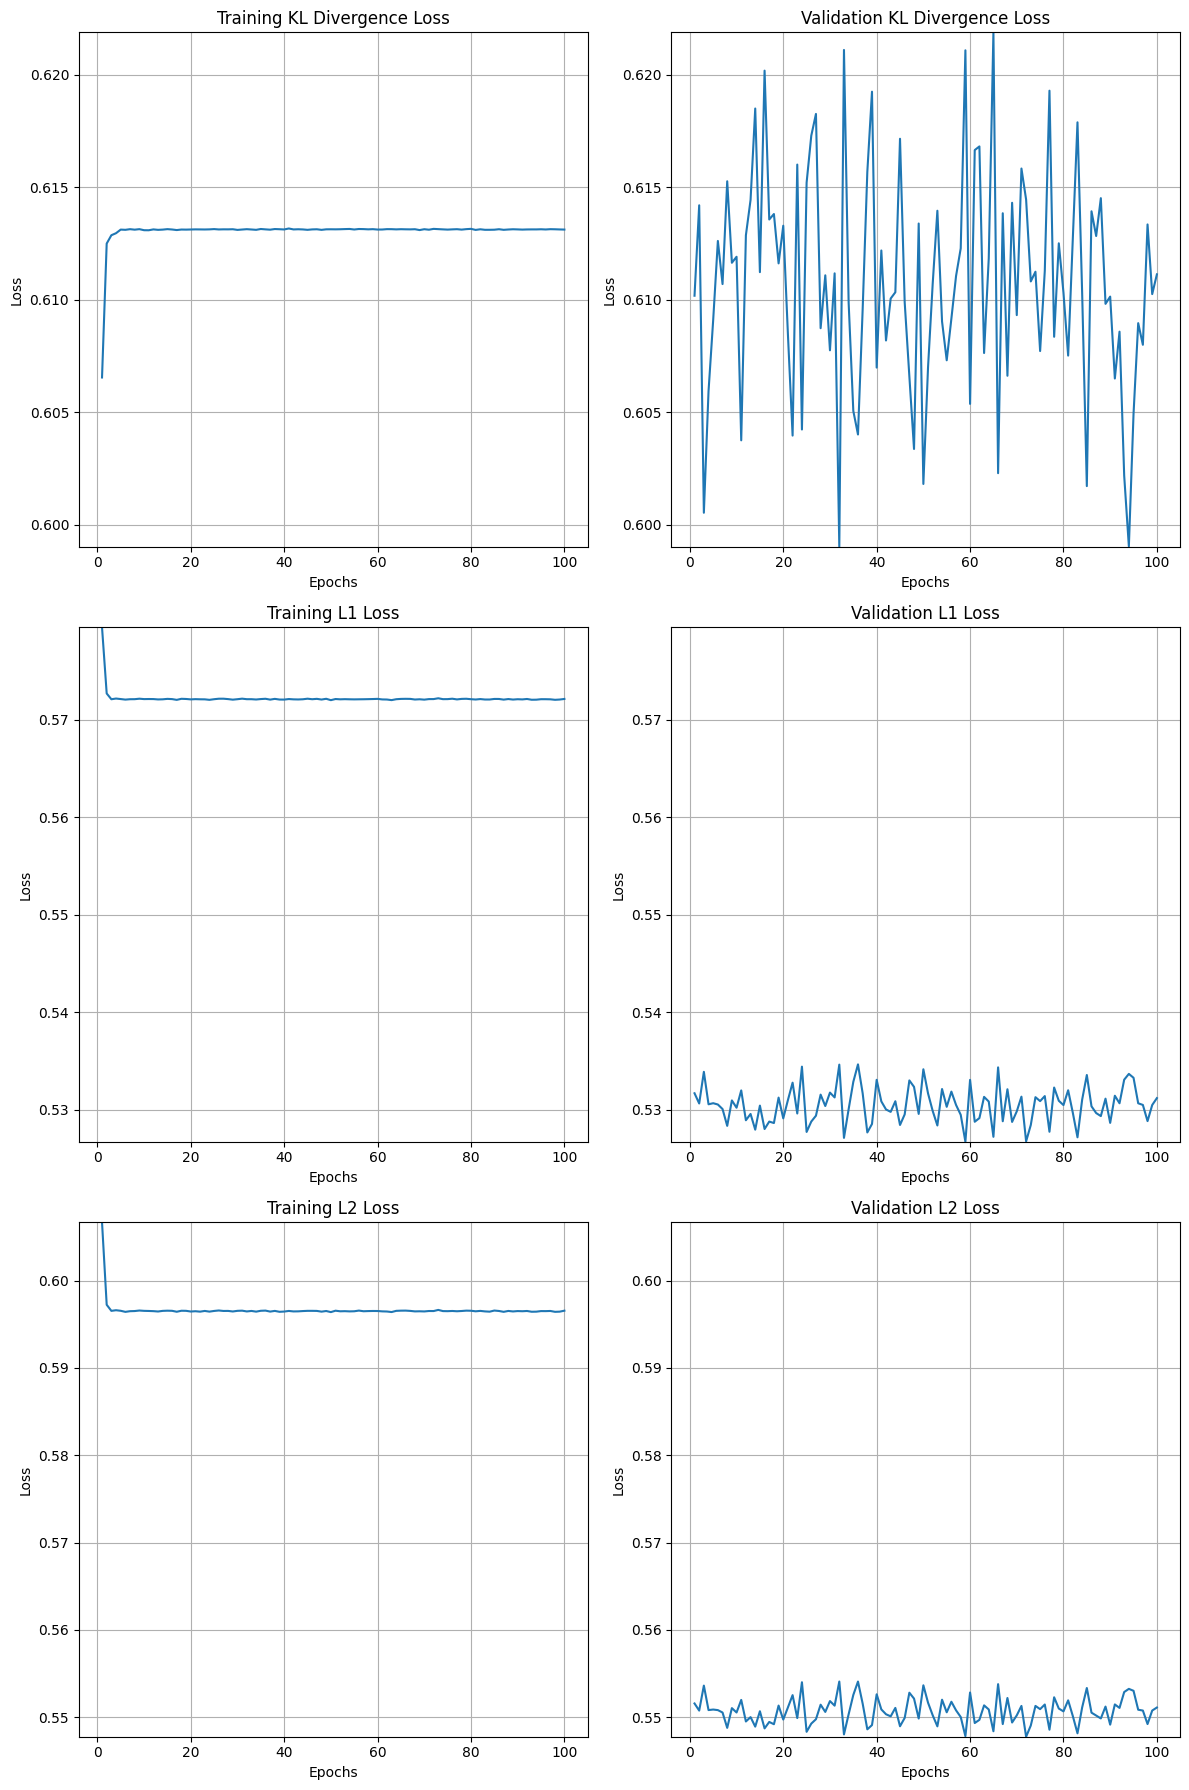

Best Validation Loss in Kelvins:
55.1012 K


In [9]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [10]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 195/195 [01:13<00:00,  2.64it/s]


z0: 0.0006
z1: -0.0191
z2: -0.0223
z3: -0.0012


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 655.48it/s]


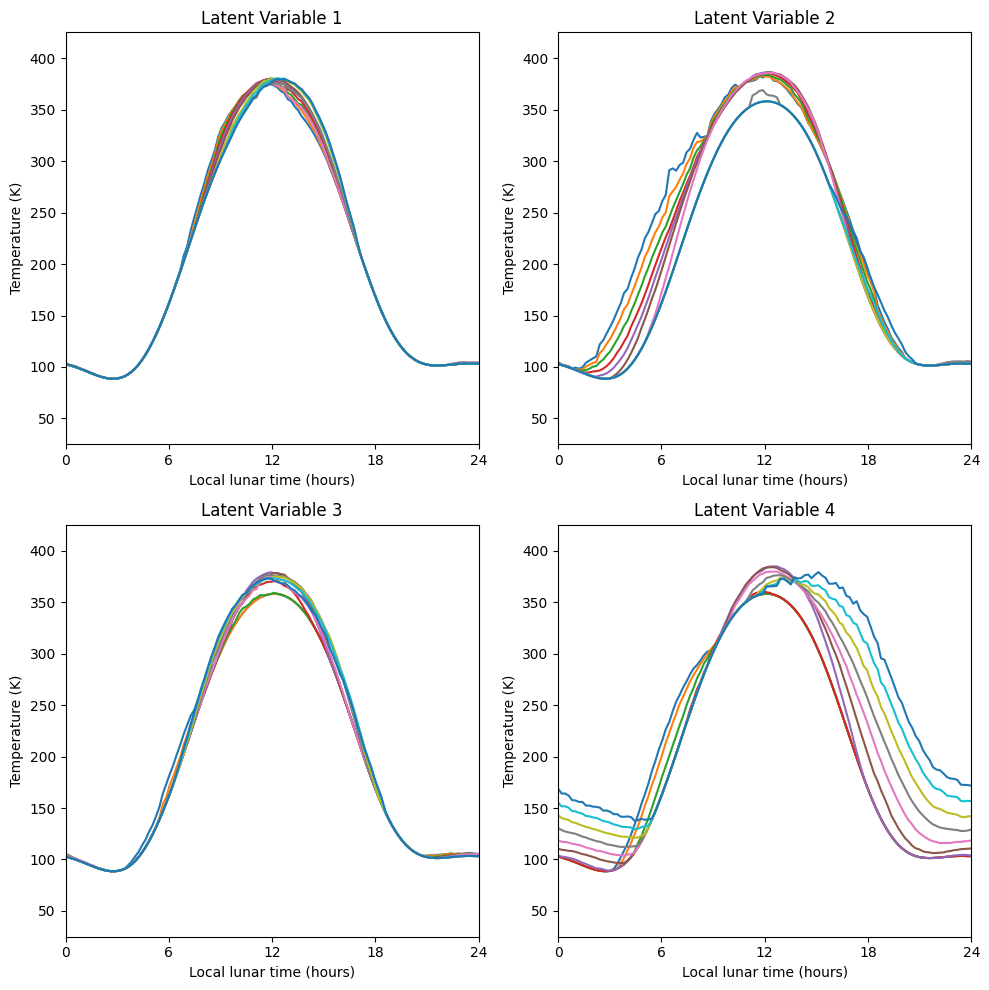

In [11]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)